# A PyTorch workflow

1. Get data ready and turn into tensors

2. Build or pick a pretrained model

3. Fit the model to the data and make a prediction

4. Evaluate the model

5. Improve through experimentation

6. Save and reload the trained model

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.4.0'

# 1. Data (preparing and loading)

This steps contains of two parts:
- Turn your data, whatever it is, into numbers (a representation).
- Pick or build a model to learn the representation as best as possible.

In [2]:
weight = 0.5
bias = 0.4

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)     # features
y = weight * X + bias                                   # labels

In [3]:
# Create train/test split
train_split = int(0.8 * len(X))

# Shuffle the data
indices = torch.randperm(len(X))
X = X[indices]
y = y[indices]

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

The model we create is going to try and learn the relationship between `X_train` & `y_train` and then we will evaluate what it learns on `X_test` and `y_test`.

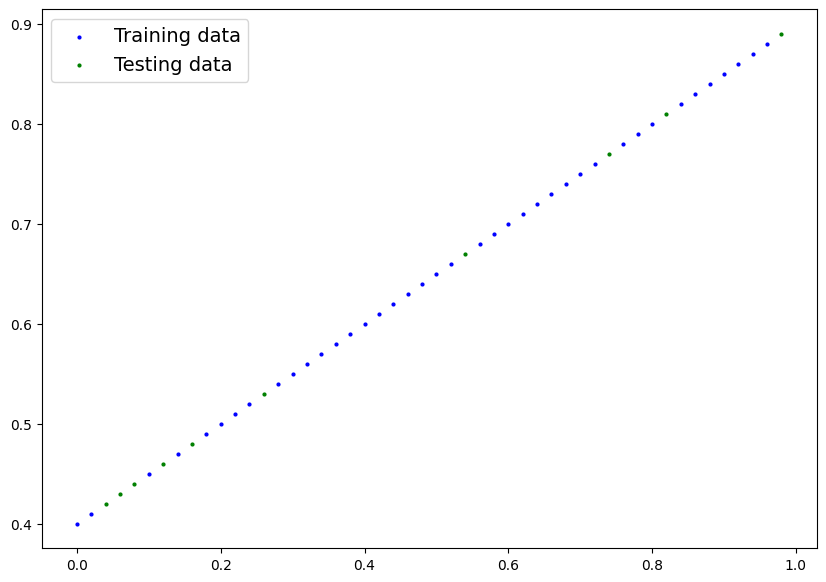

In [4]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):

    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
    
    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})

plot_predictions()

# 2. Model building

- `torch.nn`: Contains all of the building blocks for computational graphs (essentially a series of computations executed in a particular way).

- `torch.nn.Parameter`: Stores tensors that can be used with `nn.Module`. If `requires_grad=True` gradients (used for updating model parameters via gradient descent) are calculated automatically, this is often referred to as "autograd".

- `torch.nn.Module`: The base class for all neural network modules, all the building blocks for neural networks are subclasses. If you're building a neural network in PyTorch, your models should subclass `nn.Module`. Requires a `forward()` method be implemented.

- `torch.optim`: Contains various optimization algorithms (these tell the model parameters stored in `nn.Parameter` how to best change to improve gradient descent and in turn reduce the loss).

- `def forward()`: All `nn.Module` subclasses require a `forward()` method, this defines the computation that will take place on the data passed to the particular `nn.Module` (e.g. the linear regression formula above).

In [5]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()

        # initialize the weights and bias
        self.weights = nn.Parameter(torch.randn(1), requires_grad=True)
        self.bias = nn.Parameter(torch.randn(1), requires_grad=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

Check model's parameters using `.parameters()`.

In [6]:
torch.manual_seed(42)
model = LinearRegressionModel()

list(model.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

Get the state (what the model contains) of the model using `.state_dict()`.

In [7]:
model.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

## Making predictions using torch.inference_mode()
`torch.inference_mode()` turns off a bunch of things (like gradient tracking, which is necessary for training but not for inference) to make forward-passes (data going through the `forward()` method) faster.

In [8]:
with torch.inference_mode():
    y_preds = model(X_test)

# In older PyTorch code you might also see torch.no_grad() being used.
# While torch.inference_mode() and torch.no_grad() do similar things, 
# torch.inference_mode() is newer, potentially faster and preferred.


# Check the predictions
print(f"Number of testing samples: {len(X_test)}") 
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.2163],
        [0.3780],
        [0.1490],
        [0.1557],
        [0.4588],
        [0.4049],
        [0.1423],
        [0.1827],
        [0.3106],
        [0.1692]])


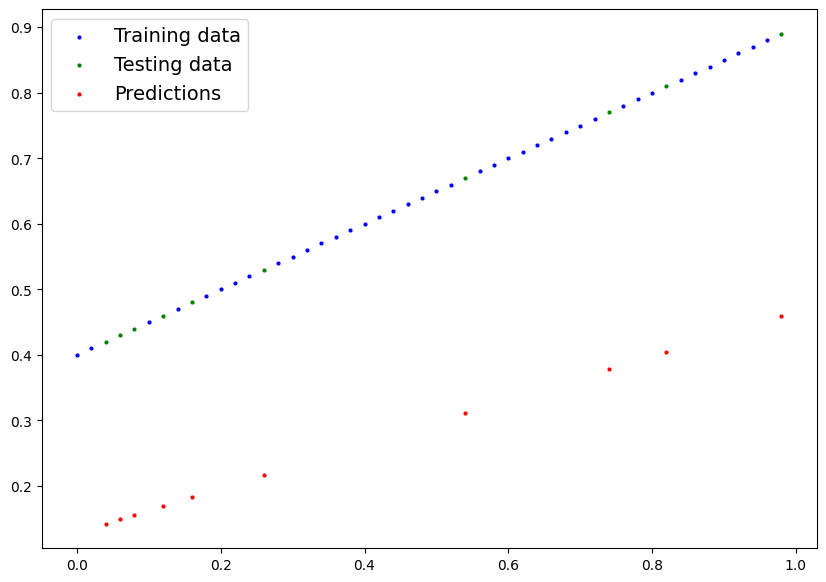

In [9]:
plot_predictions(predictions=y_preds)

In [10]:
y_test - y_preds

tensor([[0.3137],
        [0.3920],
        [0.2810],
        [0.2843],
        [0.4312],
        [0.4051],
        [0.2777],
        [0.2973],
        [0.3594],
        [0.2908]])

# 3. Model training
We need to create a loss function and optimizer in PyTorch

- **Loss function**: Measures how wrong your model's predictions. PyTorch has plenty of built-in loss functions in `torch.nn`.
    - Mean absolute error (MAE) for regression problems (`torch.nn.L1Loss()`). 
    - Binary cross entropy for binary classification problems (`torch.nn.BCELoss()`).

- **Optimizer**: Tells your model how to update its internal parameters to best lower the loss. You can find various optimization function implementations in `torch.optim`.
    - Stochastic gradient descent (`torch.optim.SGD()`). 
    - Adam optimizer (`torch.optim.Adam()`).

In [11]:
# Let's use MAE (which is under torch.nn.L1Loss()) in PyTorch as our loss function.
# We'll use SGD, torch.optim.SGD(params, lr)
# params is the target model parameters you'd like to optimize (e.g. the weights and bias values).
# lr is the learning rate you'd like the optimizer to update the parameters at.

# Loss function
loss_fn = nn.L1Loss()

# Optimizer
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

In [ ]:
torch.manual_seed(42)

epochs = 100

train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    model.train()

    y_preds = model(X_train)
    loss = loss_fn(y_preds, y_train)

    # Zero out the gradients
    optimizer.zero_grad()

    # Calculate gradients
    loss.backward()

    # Update the weights
    optimizer.step()

    # Testing the model for every epoch
    model.eval()
    with torch.inference_mode():
        test_preds = model(X_test)
        test_loss = loss_fn(test_preds, y_test)

        if (epoch % 10 == 0):
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())

            print(f"Epoch {epoch} - Training loss: {loss.item()}, Testing loss: {test_loss.item()}")

Epoch 0 - Training loss: 0.005132695194333792, Testing loss: 0.008146894164383411
Epoch 10 - Training loss: 0.005132695194333792, Testing loss: 0.008146894164383411
Epoch 20 - Training loss: 0.005132695194333792, Testing loss: 0.008146894164383411
Epoch 30 - Training loss: 0.005132695194333792, Testing loss: 0.008146894164383411
Epoch 40 - Training loss: 0.005132695194333792, Testing loss: 0.008146894164383411
Epoch 50 - Training loss: 0.005132695194333792, Testing loss: 0.008146894164383411
Epoch 60 - Training loss: 0.005132695194333792, Testing loss: 0.008146894164383411
Epoch 70 - Training loss: 0.005132695194333792, Testing loss: 0.008146894164383411
Epoch 80 - Training loss: 0.005132695194333792, Testing loss: 0.008146894164383411
Epoch 90 - Training loss: 0.005132695194333792, Testing loss: 0.008146894164383411
Epoch 100 - Training loss: 0.005132695194333792, Testing loss: 0.008146894164383411
Epoch 110 - Training loss: 0.005132695194333792, Testing loss: 0.008146894164383411
Epo

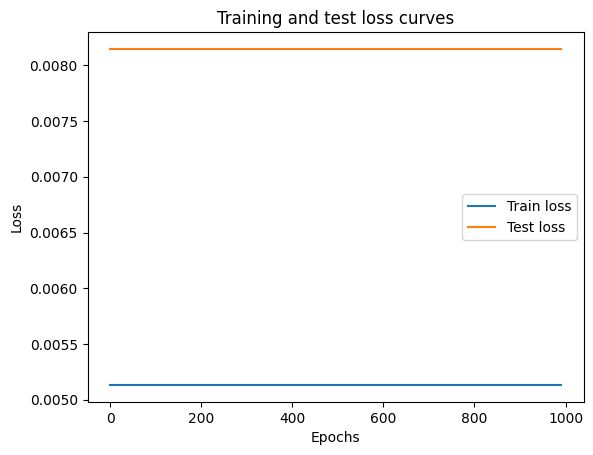

In [19]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [20]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.4905])), ('bias', tensor([0.3998]))])

And the original values for weights and bias are:
weights: 0.5, bias: 0.4


# 4. Inference

1. Set the model in evaluation mode (`model.eval()`).

2. Make the predictions using the inference mode context manager (`with torch.inference_mode():`).

3. All predictions should be made with objects on the same device (e.g. data and model on GPU only or data and model on CPU only).

In [21]:
# Set the model in evaluation mode
model.eval()

# Setup the inference mode context manager
with torch.inference_mode():
    y_preds = model(X_test)

y_preds

tensor([[0.5273],
        [0.7627],
        [0.4292],
        [0.4390],
        [0.8805],
        [0.8020],
        [0.4194],
        [0.4783],
        [0.6647],
        [0.4587]])

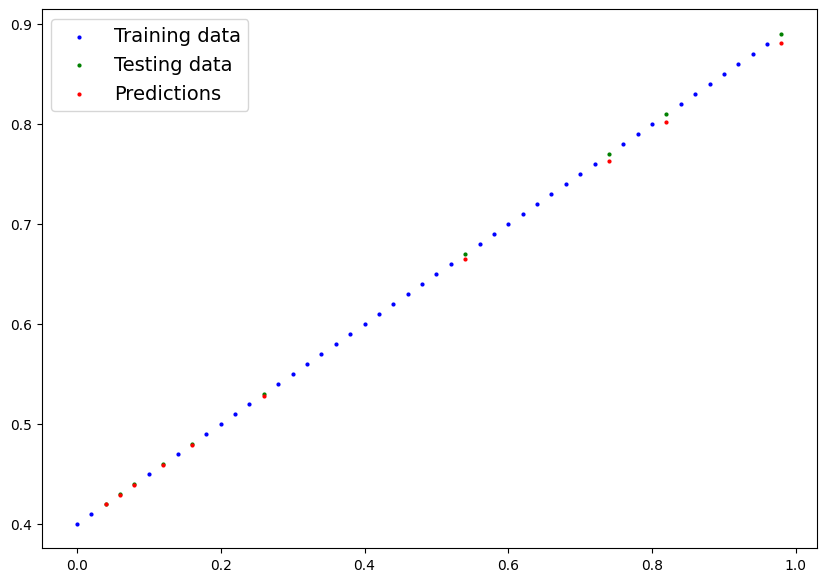

In [22]:
plot_predictions(predictions=y_preds)

# 5. Saving and loading a PyTorch model

For saving and loading models in PyTorch, there are three main methods you should be aware of

- `torch.save`: Saves a serialized object to disk using Python's pickle utility. Models, tensors and various other Python objects like dictionaries can be saved using `torch.save`.

- `torch.load`: Uses pickle's unpickling features to deserialize and load pickled Python object files (like models, tensors or dictionaries) into memory. You can also set which device to load the object to (CPU, GPU etc).

- `torch.nn.Module.load_state_dict`: Loads a model's parameter dictionary (`model.state_dict()`) using a saved `state_dict()` object.

The recommended way for saving and loading a model for inference (making predictions) is by saving and loading a model's `state_dict()`.

In [25]:
import os

os.makedirs("models", exist_ok=True)

model_save_path = os.path.join("models", "linear_regression_model.pth")

# 3. Save the model state dict 
print(f"Saving model to: {model_save_path}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=model_save_path) 

Saving model to: models/linear_regression_model.pth


## Why not save the entire model?
Saving the entire model rather than just the `state_dict()` is more intuitive, however, to quote the PyTorch documentation (italics mine):

*The disadvantage of this approach (saving the whole model) is that the serialized data is bound to the specific classes and the exact directory structure used when the model is saved...*

*Because of this, your code can break in various ways when used in other projects or after refactors.*

In [28]:
loaded_model = LinearRegressionModel()
loaded_model.load_state_dict(torch.load(f=model_save_path, weights_only=True))

<All keys matched successfully>

In [29]:
loaded_model.eval()

with torch.inference_mode():
    loaded_model_preds = loaded_model(X_test)

loaded_model_preds == y_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])